In [1]:
import requests

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact, interactive
import itertools
import hashlib
from scipy.stats import poisson, norm, gamma
import plotly.graph_objs as go
#!pip install pymc3
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
sns.set(style="dark")
plt.style.use("ggplot")
import plotly.express as px

try:
    from pymc3 import *
    import pymc3 as pm
except:
    ! pip install pymc3
    from pymc3 import *
    import pymc3 as pm

import arviz as az

# Modeling Highway Fatalities

In [2]:
url = "https://data.bts.gov/resource/crem-w557.json"
r = requests.get(url)
data = pd.DataFrame(r.json())
mob_data = data.drop(['index'], axis = 1)
date_dict = {'01': 'Jan',
             '02': 'Feb',
             '03': 'Mar',
             '04': 'Apr',
             '05': 'May',
             '06': 'Jun',
             '07': 'Jul',
             '08': 'Aug',
             '09': 'Sep',
             '10': 'Oct',
             '11': 'Nov',
             '12': 'Dec'}

fatalities = mob_data[~mob_data['safety_highway_fatalities_1'].isna()]
fatalities = fatalities[['date','safety_highway_fatalities_1','highway_fuel_prices_regular', 'transportation_economic_3', 
                         'transportation_economic_2', 'general_economic_indicators_2',
                         'auto_sales', 'capital_expenditures_state_47']]
fatalities.columns = ['date', 'fatalities', 'gas_price', 'truck_employ', 'pers_spend', 'lab_force_partic', 'auto_sales', 'highway_spending']
fatalities['month'] = fatalities['date'].apply(lambda x: x[5:7])
fatalities['month'] = fatalities['month'].map(date_dict)
fatalities = fatalities.join(pd.get_dummies(fatalities.month, prefix='month'))
fatalities['highway_spending'] = fatalities['highway_spending'].apply(lambda x: float(x)) / 100000000

fatalities['gas_price'] = fatalities['gas_price'].apply(lambda x: float(x))
fatalities['truck_employ'] = fatalities['truck_employ'].apply(lambda x: float(x))
fatalities['pers_spend'] = fatalities['pers_spend'].apply(lambda x: float(x)) / 100000
fatalities['lab_force_partic'] = fatalities['lab_force_partic'].apply(lambda x: float(x))
fatalities['auto_sales'] = fatalities['auto_sales'].apply(lambda x: float(x))
fatalities['fatalities'] = fatalities['fatalities'].apply(lambda x: float(x)) * 100
fatalities['log_truck_employ'] = fatalities['truck_employ'].apply(lambda x: np.log(x))
fatalities.head()

,date,fatalities,gas_price,truck_employ,pers_spend,lab_force_partic,auto_sales,highway_spending,month,month_Apr,month_Jan,month_Jul,month_Oct,log_truck_employ
732,2008-01-01T00:00:00.000,122.0,3.043,1391900.0,3535940.0,0.662,495800.0,36.84,Jan,0,1,0,0,14.146180
735,2008-04-01T00:00:00.000,125.0,3.458,1394400.0,3491970.0,0.659,656800.0,57.74,Apr,1,0,0,0,14.147975
738,2008-07-01T00:00:00.000,133.0,4.062,1404300.0,3432790.0,0.661,618800.0,88.05,Jul,0,0,1,0,14.155050
741,2008-10-01T00:00:00.000,132.0,3.051,1386800.0,3313030.0,0.660,427100.0,85.45,Oct,0,0,0,1,14.142509
744,2009-01-01T00:00:00.000,109.0,1.788,1287600.0,3233560.0,0.657,312700.0,37.69,Jan,0,1,0,0,14.068291


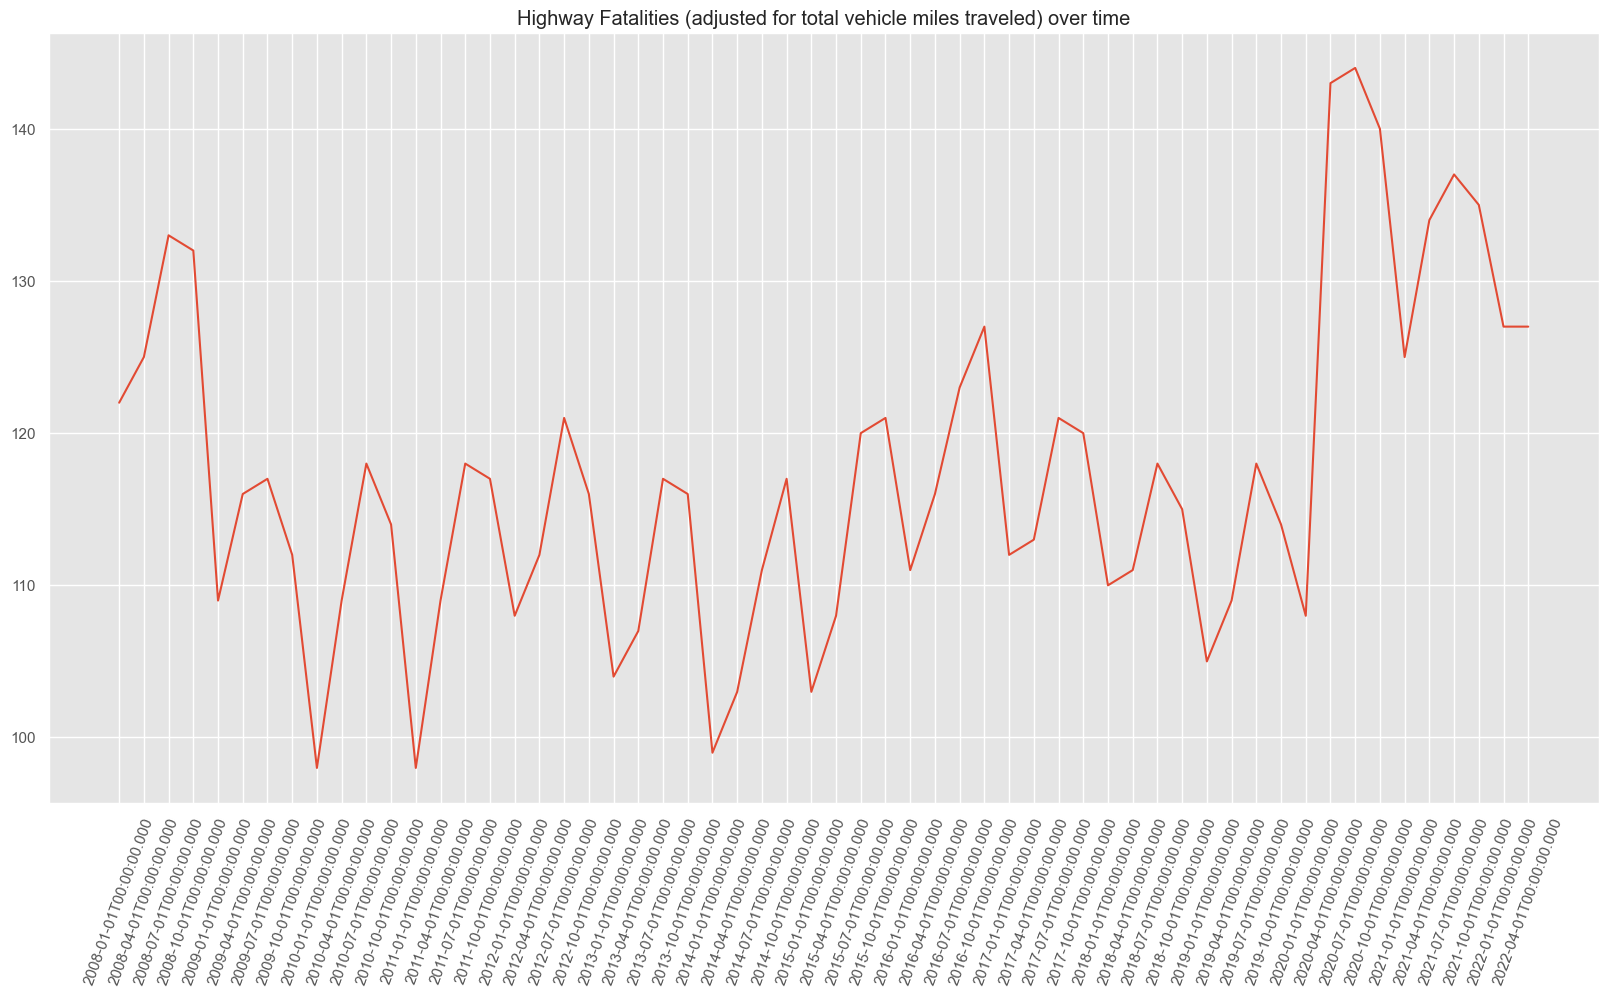

In [3]:
plt.figure(figsize=(20, 10))
plt.plot(fatalities['date'], fatalities["fatalities"].apply(lambda x: float(x)))
plt.title("Highway Fatalities (adjusted for total vehicle miles traveled) over time")
plt.xticks(rotation=70)
plt.show();

Let $X=$ # of Highway Fatalities, and 

$$\lambda_i = exp(\beta X)$$
$$X_{t} \sim Poisson(\lambda_{i})$$

where $\beta$ is our vector of coefficients, and X our vector of features





NameError: name 'model_train' is not defined

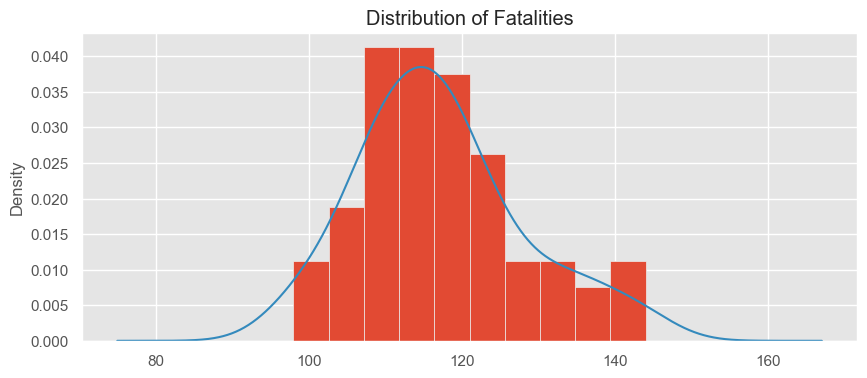

In [4]:
fig, ax = plt.subplots(figsize = (10,4))

fatalities['fatalities'].plot(kind = "hist", density = True, bins = 10)
fatalities['fatalities'].plot(kind='kde')
plt.title('Distribution of Fatalities');

print(f"Mean of Fatalities Distribution: {model_train['fatalities'].mean()}")
print(f"Variance of Fatalities Distribution: {model_train['fatalities'].var()}")

In [ ]:
with pm.Model() as simple_bayes_model:
    mu = pm.Gamma('mu', alpha=3, beta=1)
    counts = pm.Poisson('C', mu=mu, observed=model_train.fatalities)
    simple_trace_poisson = pm.sample(1000, cores=2, target_accept=0.95, init='adapt_diag')
    
with simple_bayes_model:
        simple_bayes_ppc = pm.sample_posterior_predictive(simple_trace_poisson)
        simple_bayes_ppc['C'] = simple_bayes_ppc['C'] + 0.0

ppc_data = az.from_pymc3(simple_trace_poisson, posterior_predictive=simple_bayes_ppc)
az.plot_ppc(ppc_data)
plt.xlabel('C = Number of fatalities')
plt.title('Bayesian Poisson Rate Estimation without Covariates')
plt.show();

## Comparing Frequentist Linear Regression with Negative Binomial Regression

In [ ]:
def mse(y, y_hat):
    y = np.array(y)
    y_hat = np.array(y_hat)
    return np.sum((y - y_hat)**2) / len(y)

In [ ]:
from sklearn.linear_model import LinearRegression as lr




X = fatalities[['date','gas_price', 'log_truck_employ', 
                'pers_spend', 'lab_force_partic', 'auto_sales', 'highway_spending',
               'month_Apr', 'month_Jan', 'month_Jul', 'month_Oct']]
y = fatalities['fatalities']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model_train = X_train.join(y_train)


reg = lr().fit(X_train[['gas_price', 'log_truck_employ', 
                'pers_spend', 'lab_force_partic', 'auto_sales', 'highway_spending',
               'month_Apr', 'month_Jan', 'month_Jul', 'month_Oct']], y_train)
y_hat_OLS = reg.predict(X_test[['gas_price', 'log_truck_employ', 
                'pers_spend', 'lab_force_partic', 'auto_sales', 'highway_spending',
               'month_Apr', 'month_Jan', 'month_Jul', 'month_Oct']])

X_test.sort_values(by='date',inplace=True)
plt.figure(figsize=(20, 10))
plt.plot(X_test['date'], y_hat_OLS, label='Linear_y_hat')
plt.plot(X_test['date'], y_test, label='y')
plt.legend()
plt.title("OLS linear regression on Test Data - fatalities on time of year")
plt.xticks(rotation=70)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

p_model = sm.GLM(np.array(y_train), np.array(X_train[['gas_price', 'log_truck_employ', 
                'pers_spend', 'lab_force_partic', 'auto_sales', 'highway_spending',
               'month_Apr', 'month_Jan', 'month_Jul', 'month_Oct']]), family=sm.families.Poisson())
result = p_model.fit()
result.summary()


y_hat_p = result.predict(np.array(X_test[['gas_price', 'log_truck_employ', 
                'pers_spend', 'lab_force_partic', 'auto_sales', 'highway_spending',
               'month_Apr', 'month_Jan', 'month_Jul', 'month_Oct']]))



X_test.sort_values(by='date',inplace=True)
plt.plot(X_test['date'], y_hat_p, label='Poisson_y_hat')
plt.legend()
plt.title("Frequentist Negative Binomial vs Linear regression on Test Data - fatalities on time of year")
plt.xticks(rotation=70)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

poission_model = sm.GLM(np.array(y_train), np.array(X_train[['gas_price', 'log_truck_employ', 
                'pers_spend', 'lab_force_partic', 'auto_sales', 'highway_spending',
               'month_Apr', 'month_Jan', 'month_Jul', 'month_Oct']]), family=sm.families.NegativeBinomial())
result = poission_model.fit()
result.summary()


y_hat_poisson = result.predict(np.array(X_test[['gas_price', 'log_truck_employ', 
                'pers_spend', 'lab_force_partic', 'auto_sales', 'highway_spending',
               'month_Apr', 'month_Jan', 'month_Jul', 'month_Oct']]))



X_test.sort_values(by='date',inplace=True)
plt.plot(X_test['date'], y_hat_poisson, label='Negative_Binomial_y_hat')
plt.legend()
plt.title("Frequentist Negative Binomial vs Linear regression on Test Data - fatalities on time of year")
plt.xticks(rotation=70)
plt.show();

plt.scatter(X_test['date'], y_hat_poisson - y_test, label = 'Negative Binomial')
plt.scatter(X_test['date'], y_hat_OLS - y_test, label = 'Linear Regression')
plt.scatter(X_test['date'], y_hat_p - y_test, label = 'Poisson')

plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residuals from Frequentist Negative Binomial vs. Linear Regression on Test Data")
plt.xticks(rotation=70)
plt.legend()
plt.show();

print("-"*20)
print(f"Linear MSE:{mse(y_test, y_hat_OLS)}")
print(f"Neg Bimom MSE:{mse(y_test, y_hat_poisson)}")
print(f"Poisson MSE:{mse(y_test, y_hat_p)}")
pd.DataFrame(reg.coef_, ['gas_price', 'log_truck_employ', 
                'pers_spend', 'lab_force_partic', 'auto_sales', 'highway_spending',
               'month_Apr', 'month_Jan', 'month_Jul', 'month_Oct'])

Appears this model is overestimating, lets try Poisson Regression

### Note

Distributions mean and variance are relatively close, so using a Poisson likelihood makes sense

## Running a Baysien Poisson Regression and comparing results

In [67]:
with pm.Model() as mdl_fish:

    # define priors, weakly informative Normal
    b1 = pm.Gamma("month_Jan", alpha=10, beta=5)
    b2 = pm.Gamma("month_Apr", alpha=10, beta=5)
    b3 = pm.Gamma("month_Jul", alpha=10, beta=5)
    b4 = pm.Gamma("month_Oct", alpha=10, beta=5)
    
#     b5 = pm.Normal('gas_price', mu=2, sigma=10)
#     b6 = pm.Gamma('truck_employ', alpha=10, beta=5)
#     b7 = pm.Gamma('pers_spend', alpha=10, beta=5)
#     b8 = pm.Gamma('lab_force_partic', alpha=10, beta=5)
    
#     b9 = pm.Gamma('auto_sales', alpha=10, beta=5)
    b10 = pm.Normal('highway_spending', mu=0, sigma=2)
    
    
    # define linear model and exp link function
    theta = b1 * model_train["month_Jan"] + b2 * model_train["month_Apr"] + \
    b3 * model_train["month_Jul"] + b4 * model_train['month_Oct'] + \
    b10 * model_train['highway_spending']
    
#     b5 * model_train["gas_price"] +
#     + b6 * model_train['truck_employ'] + \
#     b7 * model_train["pers_spend"] + b8 * model_train['lab_force_partic'] + \
#     b9 * model_train["auto_sales"] + b10 * model_train['highway_spending']
    
    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=np.exp(theta), observed=model_train["fatalities"].values)

In [68]:
with mdl_fish:
    inf_fish = pm.sample(1000, tune=1000, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [highway_spending, month_Oct, month_Jul, month_Apr, month_Jan]


RuntimeError: Chain 1 failed.

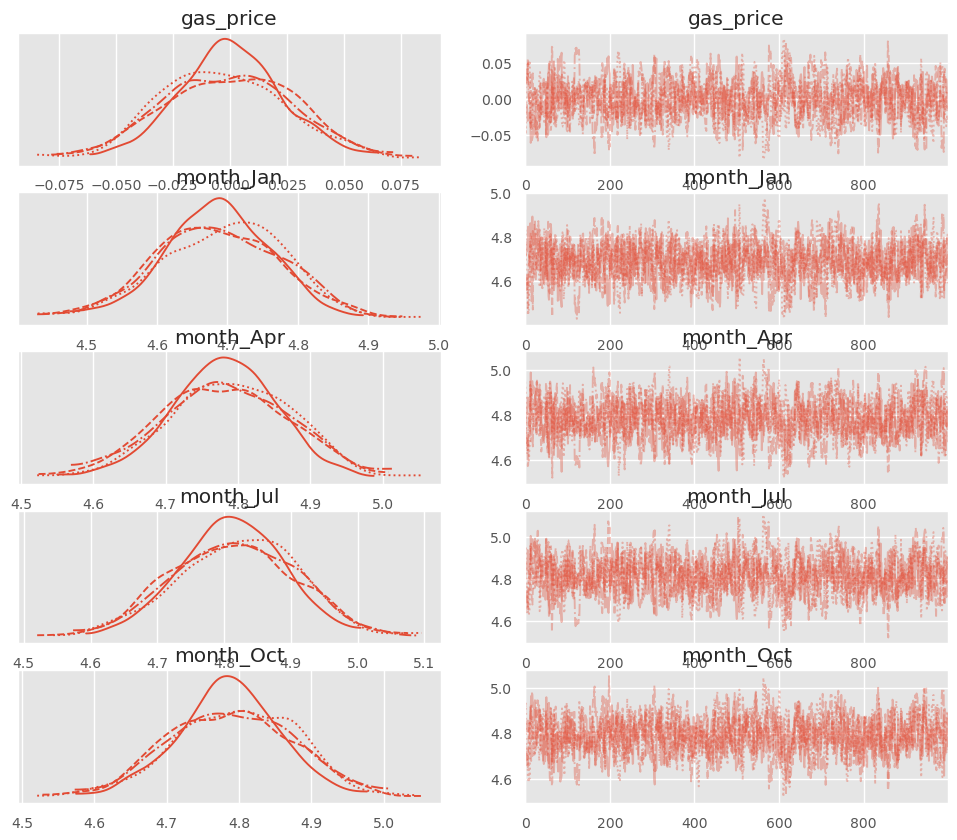

In [49]:
az.plot_trace(inf_fish);

In [50]:
poisson_coeffs = az.summary(np.exp(inf_fish.posterior), kind="stats")
poisson_coeffs

,mean,sd,hdi_3%,hdi_97%
gas_price,1.000,0.027,0.951,1.051
month_Jan,109.014,9.254,91.253,125.785
month_Apr,119.983,10.061,102.618,140.113
month_Jul,123.845,10.965,102.873,143.180
month_Oct,120.665,9.739,102.901,138.540
